
Last recorded fuel price: 2.47 AED

=== Model Performance ===
MAE: 0.1359
R² Score: 0.5377

Forecast for next month: 2.41 AED
Change from current: -0.06 AED

Expected decrease of 0.06 AED (2.3%)


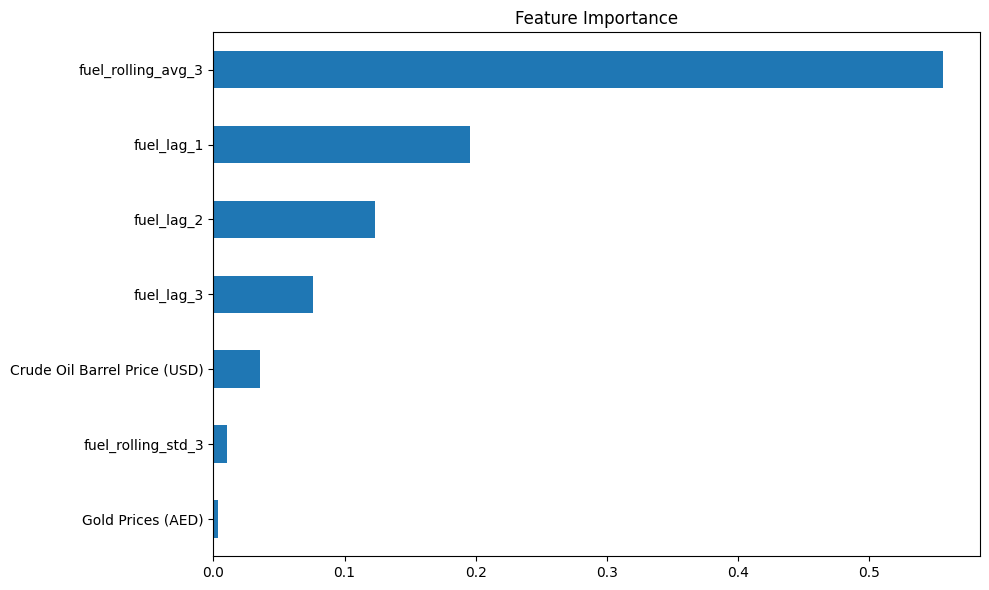

In [ ]:
# XGBOOST V2.1
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
!pip install scikit-optimize
from skopt import BayesSearchCV
import joblib
import warnings

df = pd.read_excel("FuelData.xlsx", index_col=0, parse_dates=True)
df.sort_index(inplace=True)

def add_time_series_features(df):
    df = df.copy()
    for lag in range (1,4):
        df[f'fuel_lag_{lag}'] = df["Fuel price(AED)"].shift(lag)
    df['fuel_rolling_avg_3'] = df["Fuel price(AED)"].rolling(3).mean()
    df['fuel_rolling_std_3'] = df["Fuel price(AED)"].rolling(3).std()


    if 'Gold price' in df.columns:
        for lag in range (1,4):
            df[f'gold_lag_{lag}'] = df["Gold price"].shift(lag)
        df['gold_rolling_avg_3'] = df["Gold price"].rolling(3).mean()
        df['gold_rolling_std_3'] = df["Gold price"].rolling(3).std()

        df['fuel_gold_corr_3'] = df["Fuel price(AED)"].rolling(3).corr(df["Gold price"])
        df['fuel_gold_ratio'] = df["Fuel price(AED)"] / df["Gold price"]

    return df.dropna()

df = add_time_series_features(df)

this_month_price = df["Fuel price(AED)"].iloc[-1]
print(f"\nLast recorded fuel price: {this_month_price:.2f} AED")

X = df.drop(columns=["Fuel price(AED)"])
y = df["Fuel price(AED)"]

tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

pipe = Pipeline([
    ('encoder', TargetEncoder()),
    ('regressor', XGBRegressor(
        random_state=8,
        enable_categorical=True
    ))
])

param_grid = {
    'regressor__n_estimators': (50, 100),
    'regressor__learning_rate': (0.01, 0.9, 'log-uniform'),
    'regressor__max_depth': (1, 9),
    'regressor__subsample': (0.4, 1.0),
    'regressor__colsample_bytree': (0.4, 1.0)
}

opt = BayesSearchCV(
    pipe,
    param_grid,
    n_iter=25,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    random_state=8,
    n_jobs=-1
)

opt.fit(X_train, y_train)

best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Model Performance ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

joblib.dump(best_model, "fuel_price_predictor_xgboost_v2.pkl")

def forecast_next_month(df, model, current_price=None):
    """Properly handles the last known price and feature updates"""
    last_known = df.iloc[-1].copy()

    current_fuel_price = current_price if current_price else last_known['Fuel price(AED)']

    next_features = last_known.drop('Fuel price(AED)').to_dict()

    next_features.update({
        'fuel_lag_1': current_fuel_price,
        'fuel_lag_2': last_known['fuel_lag_1'],
        'fuel_lag_3': last_known['fuel_lag_2'],
        'fuel_rolling_avg_3': np.mean([current_fuel_price,
                                      last_known['fuel_lag_1'],
                                      last_known['fuel_lag_2']]),
        'fuel_rolling_std_3': np.std([current_fuel_price,
                                     last_known['fuel_lag_1'],
                                     last_known['fuel_lag_2']])
    })

    if 'Gold price' in df.columns:
        next_features.update({
            'gold_lag_1': last_known['Gold price'],
            'gold_lag_2': last_known['gold_lag_1'],
            'gold_lag_3': last_known['gold_lag_2'],
            'gold_rolling_avg_3': np.mean([last_known['Gold price'],
                                         last_known['gold_lag_1'],
                                         last_known['gold_lag_2']]),
            'gold_rolling_std_3': np.std([last_known['Gold price'],
                                        last_known['gold_lag_1'],
                                        last_known['gold_lag_2']]),
            'fuel_gold_corr_3': np.corrcoef([
                [current_fuel_price, last_known['fuel_lag_1'], last_known['fuel_lag_2']],
                [last_known['Gold price'], last_known['gold_lag_1'], last_known['gold_lag_2']]
            ])[0, 1],
            'fuel_gold_ratio': current_fuel_price / last_known['Gold price']
        })

    next_input = pd.DataFrame([next_features])
    return model.predict(next_input)[0]

next_month_pred = forecast_next_month(df, best_model, current_price=this_month_price)

print(f"\nForecast for next month: {next_month_pred:.2f} AED")
print(f"Change from current: {next_month_pred - this_month_price:.2f} AED")

if next_month_pred < this_month_price:
  print("Price will decrease")
else:
  print("Price will increase")


def analyze_trend(current, predicted):
    change = predicted - current
    pct_change = (abs(change) / current) * 100
    direction = "increase" if change > 0 else "decrease"

    if abs(change) < 0.01:
        return "Price expected to remain stable"
    else:
        return f"Expected {direction} of {abs(change):.2f} AED ({pct_change:.1f}%)"

print("\n" + analyze_trend(this_month_price, next_month_pred))

if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    import matplotlib.pyplot as plt

    features = X.columns
    importances = best_model.named_steps['regressor'].feature_importances_

    plt.figure(figsize=(10, 6))
    pd.Series(importances, index=features).sort_values().plot(kind='barh')
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()